In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.pyplot import imread
from ffht import fht

In [3]:
seed(42)
n = 300
d = n
x = rand(d)
A = rand(n, d)
b = np.abs(A.dot(x))

In [4]:
def f(w):
    x = lstsq(A, w, rcond=None)[0]
    return np.abs((np.abs(A.dot(x)) - b)).sum()

def grad_g(w, nu):
    x_star = lstsq(A, w, rcond=None)[0]
    return 1/nu*(w - A.dot(x_star))

def prox_h(z, nu):
    y = ((abs(z) + b - nu).clip(0, None) - (-abs(z) - b - nu).clip(0, None) - b).clip(0, None)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val" : []}
    w = w0
    for i in range(1, maxIter+1):
        #nu = 1/sqrt(i)
        w = prox(w - nu*grad(w, nu), nu)
        log["func_val"].append(f(w))
    return w, log

## Dummy test

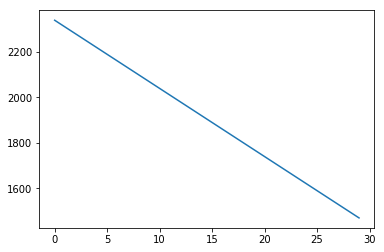

In [5]:
w_star, log = pgd(f, grad_g, prox_h, A.dot(x + 0.1*rand(d)), nu=0.1, maxIter=30)
plot(log["func_val"])

Stopping criteria?

## Real Images 

In [167]:
lewis = imread("lewis_grayscale.jpg")[:,:, 0]

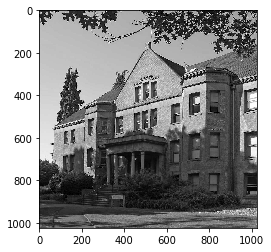

In [168]:
imshow(lewis)
gray()

In [169]:
m, n = lewis.shape
lewis = lewis.reshape(m*n)

In [170]:
def corrupt(data, p=0.1):
    noise = rand(len(data)) > p
    return data * noise

In [171]:
corrupted_lewis = corrupt(lewis, p=0.01)

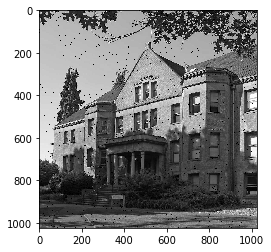

In [172]:
imshow(corrupted_lewis.reshape((m, n)))
gray()

In [173]:
def pad_to_power_of_two(arr, const=0):
    nextPower = np.ceil(np.log2((len(arr))))
    deficit = int(np.power(2, nextPower) - len(arr))
    return pad(arr, ((0, deficit)), 'constant'), deficit

#x, tail = pad_to_power_of_two(corrupted_lewis)
x0 = corrupted_lewis

k = 4
seed(42)
S = rand(k, len(x))
S = (S > 0.5)*2-1
D = zeros(k*len(x))
D[:len(x)] = S[0]*S[1] + S[0]*S[2] + S[0]*S[3]
D[len(x):2*len(x)] = S[1]*S[0] + S[1]*S[2] + S[1]*S[3]
D[2*len(x):3*len(x)] = S[2]*S[0] + S[2]*S[1] + S[2]*S[3]
D[3*len(x):] = S[3]*S[0] + S[3]*S[1] + S[3]*S[2]

b = np.abs(Adot(lewis, S = S))

In [174]:
def Adot(x, k = 4, S = S):
    m = len(x)
    result = zeros(k*m)
    for i, s in enumerate(S):
        result[i*m:i*m+m] = (s*x).astype(np.float32)
        fht(result[i*m:i*m+m])
    return result 

def Ainvdot(w, k=4, S = S):
    result = zeros(int(len(w)/k))
    m = len(result)
    for i, s in enumerate(S):
        t = w[i*m:i*m+m]
        fht(t)
        result += s*t
    return result/m

def f(w):
    return np.abs((np.abs(w) - b)).sum()

def grad_g(w, nu):
    return 1/nu*(w*(1-1/k) - 1/k*D*w)

def prox_h(z, nu):
    y = ((abs(z) + b - nu).clip(0, None) - (-abs(z) - b - nu).clip(0, None) - b).clip(0, None)
    return y*sign(z)

def pgd(f, grad, prox, w0, nu = 1, maxIter=1000, tol=1e-3):
    log = {"func_val" : []}
    w = w0
    for i in range(1, maxIter+1):
        print("f(w)", f(w))
        z = w - nu*grad(w, nu)
        print("f(z)", f(z))
        w = prox(z, nu)
        log["func_val"].append(f(w))
    return w, log

f(w) 42386308900.0
f(z) 279112850714.0
f(w) 279113044594.80023
f(z) 332740549620.9002
f(w) 332740753941.5002
f(z) 359730139397.0498
f(w) 359730347433.0001
f(z) 373253512732.2498


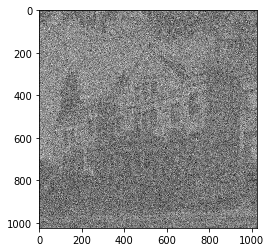

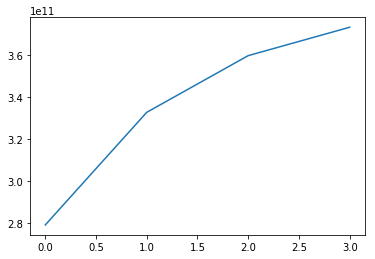

In [164]:
x0 = corrupted_lewis
w0 = Adot(x0, S = S)
w_trans, log = pgd(f, grad_g, prox_h, w0 = w0, nu = 0.1, maxIter=4, tol=1e-3)
x_trans = Ainvdot(w_trans).reshape((m, n))
imshow(x_trans)
show()
plot(log["func_val"])

## Dummy Version

In [232]:
def fht_vec(x, k = 1):
    m = int(len(x)/k)   
    result = zeros(len(x))
    for i in range(k):
        t = np.copy(x[i*m:i*m+m]).astype(float32)
        fht(t)
        result[i*m:i*m+m] = t
    return result/sqrt(len(x))

In [233]:
fht_vec(fht_vec(lewis))

array([222., 242., 181., ..., 132., 110., 127.])

In [236]:
def pgd_simple(f, prox, w0, nu = 0.1, maxIter=1000, tol=1e-3):
    log = {"func_val" : [f(w0)]}
    w = w0
    for i in range(1, maxIter+1):
        z = 1/k*(w + fht_vec(D*fht_vec(w, k=4), k=4))
        w = prox(z, nu)
        log["func_val"].append(f(w))
    return w, log

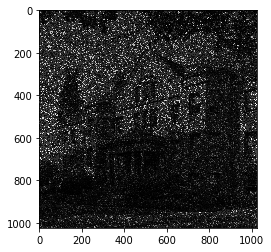

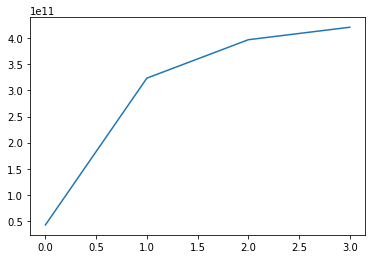

In [237]:
x0 = corrupted_lewis
w0 = Adot(x0, S = S)
w_trans, log = pgd_simple(f, prox_h, w0 = w0, nu = 0.1, maxIter=3, tol=1e-3)
x_trans = Ainvdot(w_trans).reshape((m, n))
imshow(x_trans)
show()
plot(log["func_val"])